# Rainfall vs Niño

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import df2img


sys.path.append("../../../../indicators_setup")
from ind_setup.colors import get_df_col, plotting_style
from ind_setup.tables import plot_df_table
from ind_setup.plotting_int import plot_oni_index_th
from ind_setup.plotting import plot_bar_probs_ONI

plotting_style()
from ind_setup.core import fontsize

sys.path.append("../../../functions")
from data_downloaders import GHCN, download_oni_index

## Define location and variables of interest

In [3]:
country = 'Palau'
vars_interest = ['PRCP']

## Get Data

In [4]:
df_country = GHCN.get_country_code(country)
print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

The GHCN code for Palau is PS


In [5]:
df_stations = GHCN.download_stations_info()
df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
print(f'There are {df_country_stations.shape[0]} stations in {country}')


There are 13 stations in Palau


In [6]:
GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'

## Using Koror Station

In [7]:
id = 'PSW00040309' # Koror Station
dict_prcp = GHCN.extract_dict_data_var(GHCND_dir, 'PRCP', df_country_stations.loc[df_country_stations['ID'] == id])[0]
st_data = dict_prcp[0]['data'].dropna()

## ONI index

https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

In [8]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'

In [9]:
df1 = download_oni_index(p_data)

In [10]:
lims = [-.5, .5]
plot_oni_index_th(df1, lims = lims)

In [11]:
st_data_monthly = st_data.resample('M').mean()
st_data_monthly.index = pd.DatetimeIndex(st_data_monthly.index).to_period('M').to_timestamp() + pd.offsets.MonthBegin(1)
st_data_monthly

,PRCP
DATE,
1951-08-01,7.800000
1951-09-01,16.800000
1951-10-01,7.266667
1951-11-01,5.554839
1951-12-01,9.093333
...,...
2024-10-01,13.756667
2024-11-01,7.055172
2024-12-01,7.751852


In [12]:
rolling_mean = 6 #months
df1['prcp'] = st_data_monthly['PRCP'].rolling(window=rolling_mean).mean()

<Axes: >

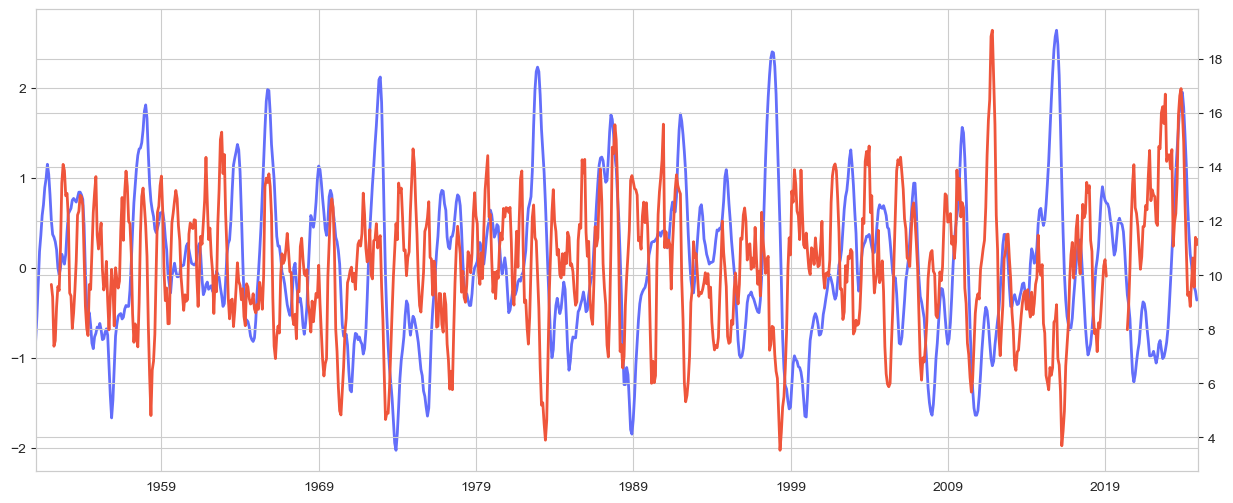

In [13]:
fig, ax = plt.subplots(figsize = [15, 6])
df1.ONI.plot(ax = ax, color = get_df_col()[0], lw = 2)

ax2 = ax.twinx()
df1.prcp.plot(ax = ax2, color = get_df_col()[1], lw = 2)
# df1.tmax.plot(ax = ax2, color = get_df_col()[1], lw = 2)
# df1.tdiff.plot(ax = ax2, color = get_df_col()[1], lw = 2)
# df1.tmean.plot(ax = ax2, color = get_df_col()[1], lw = 2)


Text(0.5, 0, 'Time')

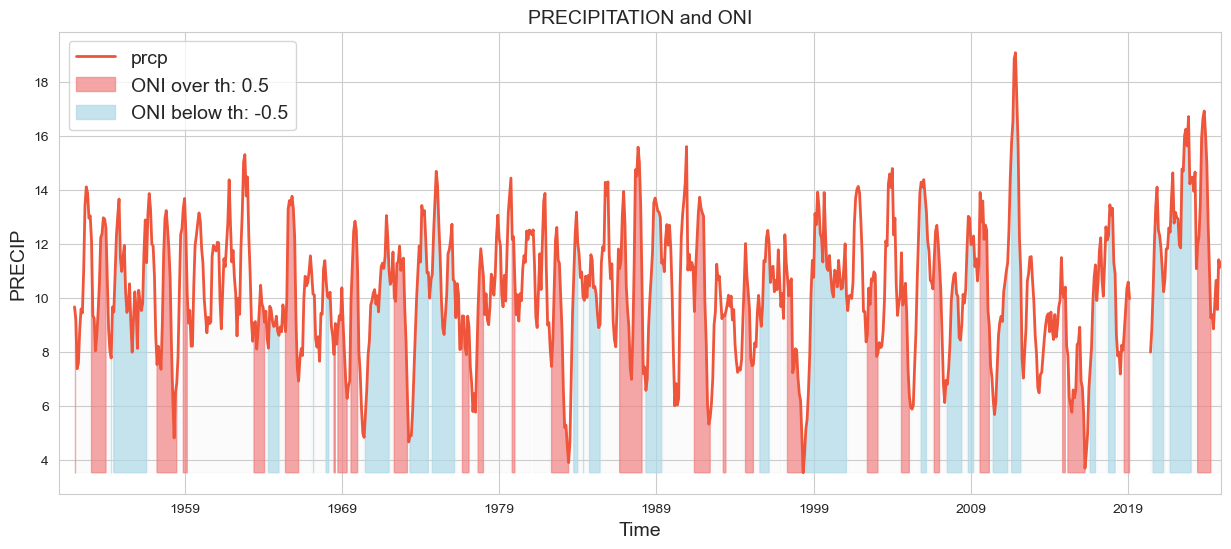

In [14]:
low_lim = np.nanmin(df1.prcp)

fig, ax = plt.subplots(figsize = [15, 6])
df1.prcp.plot(ax = ax, color = get_df_col()[1], lw = 2)

ax.fill_between(df1.index, low_lim, df1.prcp, where = (df1.ONI > lims[1]), color = 'lightcoral',
                 alpha = 0.7, label = f'ONI over th: {lims[1]}')
ax.fill_between(df1.index, low_lim, df1.prcp, where = (df1.ONI < lims[0]), color = 'lightblue', 
                alpha = 0.7, label = f'ONI below th: {lims[0]}')

ax.fill_between(df1.index, low_lim, df1.prcp, where = ((df1.ONI > lims[0]) & (df1.ONI < lims[1])),
                 color = 'lightgrey', alpha = 0.075)

ax.legend(fontsize=fontsize)
ax.set_title('PRECIPITATION and ONI', fontsize = fontsize)
ax.set_ylabel('PRECIP', fontsize = fontsize)
ax.set_xlabel('Time', fontsize = fontsize)

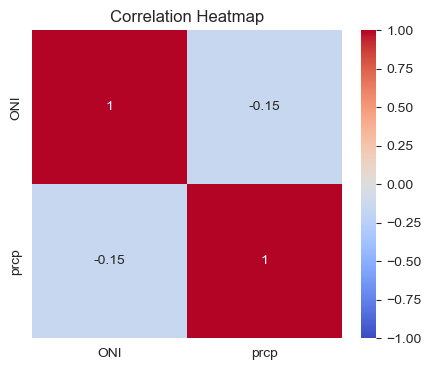

In [15]:
plt.figure(figsize=(5, 4))
sns.heatmap(df1.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

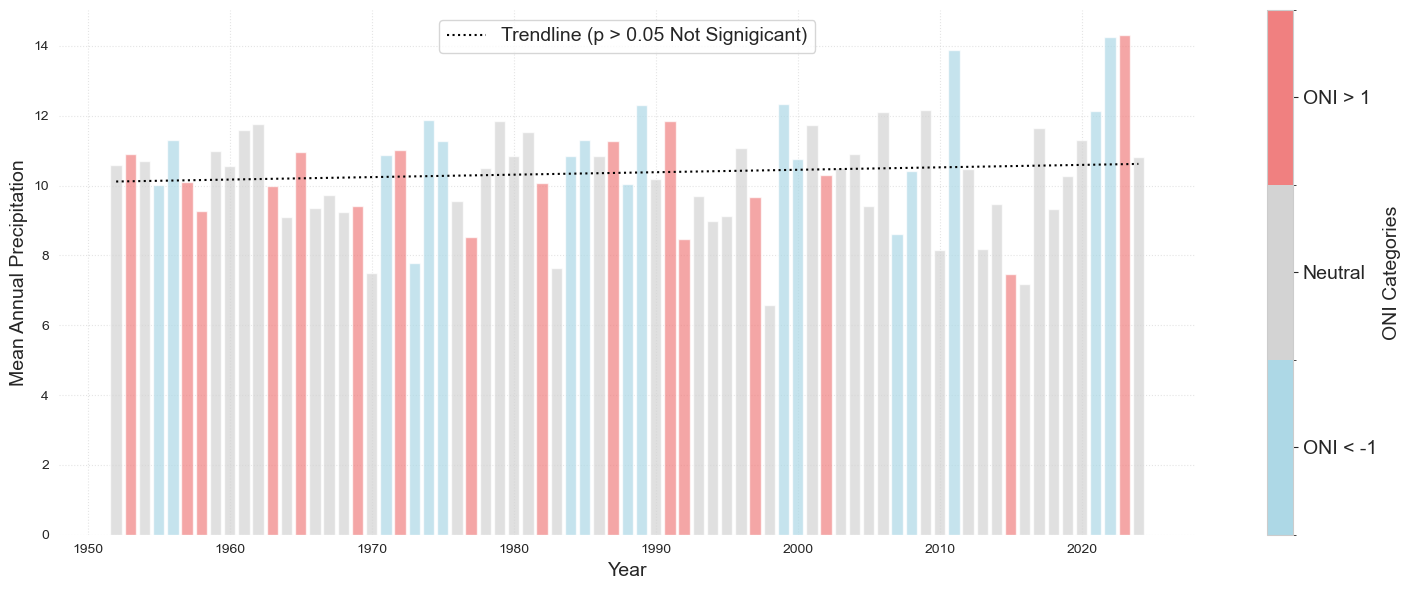

In [22]:
df2 = df1.resample('Y').mean()
df2['oni_cat'] = np.where(df2.ONI > lims[1], 1, np.where(df2.ONI < lims[0], -1, 0))   
fig = plot_bar_probs_ONI(df2, var='prcp', y_label = 'Mean Annual Precipitation')

Text(0.5, 0.98, 'Precipitation Anomaly over the 1961-1990 mean')

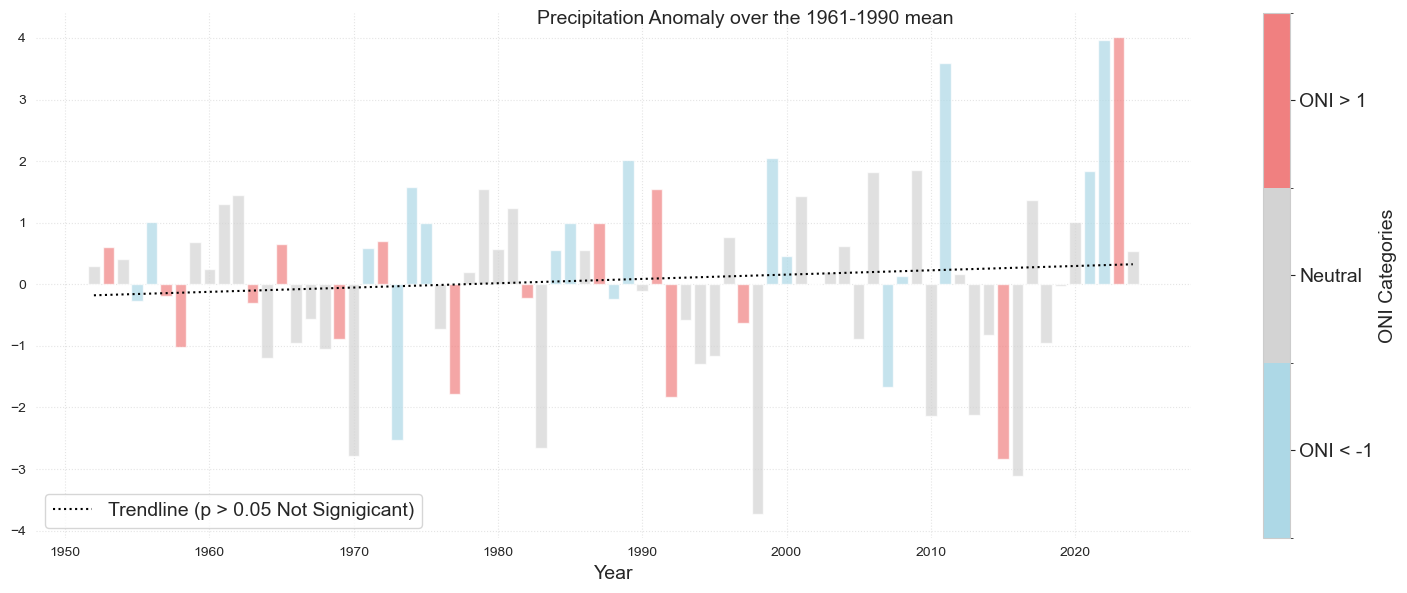

In [23]:
df2['prcp_ref'] = df2.prcp - df2.loc['1961':'1990'].prcp.mean()
fig = plot_bar_probs_ONI(df2, var='prcp_ref')
fig.suptitle('Precipitation Anomaly over the 1961-1990 mean', fontsize = fontsize)


In [24]:
df_format = np.round(df1.describe(), 2)

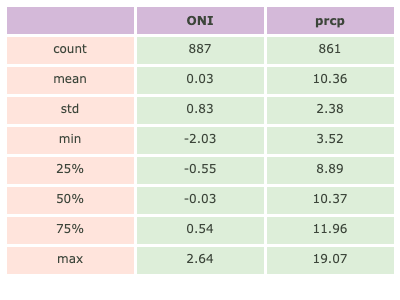

In [25]:
fig = plot_df_table(df_format, figsize = (400, 300))
df2img.save_dataframe(fig=fig, filename="getting_started.png")